In [36]:
from tensorflow import keras
from keras.utils.image_utils import load_img 
from keras.utils.image_utils import img_to_array
from keras.applications.vgg16 import preprocess_input 

In [37]:
#https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34

In [38]:
# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

In [39]:
# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [40]:
# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [41]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [86]:
img_path = "/gdrive/My Drive/Colab Notebooks/ComputerVision/ImageClustering/blurry_images/"

In [87]:
os.chdir(img_path)

In [106]:
# this list holds all the image filename
flowers = []

# creates a ScandirIterator aliased as files
with os.scandir(img_path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            flowers.append(file.name)

In [107]:
flowers 

['0156.png',
 '0166.png',
 '0168.png',
 '0169.png',
 '0170.png',
 '0167.png',
 '0165.png',
 '0164.png',
 '0155.png',
 '0160.png',
 '0163.png',
 '0162.png',
 '0157.png',
 '0161.png',
 '0158.png',
 '0159.png',
 'blur.png',
 'blur_0157.png.png',
 'blur_0156.png.png',
 'blur_0166.png.png',
 'blur_0168.png.png',
 'blur_0169.png.png',
 'blur_0170.png.png',
 'blur_0167.png.png',
 'blur_0165.png.png',
 'blur_0164.png.png',
 'blur_0155.png.png',
 'blur_0160.png.png',
 'blur_0163.png.png',
 'blur_0162.png.png',
 'blur_0161.png.png',
 'blur_0158.png.png',
 'blur_0159.png.png']

In [46]:
#flowers = ['0013.png',
# '0207.png',
# '0030.png',
# '0040.png',
# '0137.png',
# '0119.png',
# '0117.png',
# '0004.png',
# '0008.png',
# '0065.png',
# '0209.png']

In [89]:
!ls

0155.png  0157.png  0159.png  0161.png	0163.png  0165.png  0167.png  0169.png
0156.png  0158.png  0160.png  0162.png	0164.png  0166.png  0168.png  0170.png


In [100]:
def blur_image (image_name):
  # Importing Image class from PIL module
  import PIL
  from PIL import Image

  # Opens a image in RGB mode
  im = Image.open(r"{}".format(image_name))

  # Blurring the image
  im1 = im.filter(PIL.ImageFilter.BoxBlur(4))

  im1.save ("blur_{}.png".format(image_name))

In [101]:
#for im in flowers : blur_image (im)

In [108]:
len (flowers)

33

In [109]:
img = load_img(flowers[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)

(224, 224, 3)


In [110]:
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)

(1, 224, 224, 3)


In [111]:
x = preprocess_input(reshaped_img)

In [112]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [113]:
features = model.predict(reshaped_img)
print(features.shape)

1/1 [==============================] - 1s 644ms/step
(1, 4096)


In [114]:
# load the model first and pass as an argument
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [115]:
extract_features(flowers[0],model)

1/1 [==============================] - 1s 1s/step


array([[0.       , 0.       , 1.5211254, ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [116]:
data = {}
#loop through each image in the dataset
for flower in flowers:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(flower,model)
        data [flower] = feat
    except:
      continue     

1/1 [==============================] - 1s 503ms/step


In [117]:
len (data)

33

In [118]:
list (data.values()) [0]

array([[0.       , 0.       , 1.5211254, ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [119]:
list (data.values()) [0].shape

(1, 4096)

In [120]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

In [121]:
# get a list of just the features
feat = np.array(list(data.values()))
feat.shape

(33, 1, 4096)

In [122]:
# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape

(33, 4096)

In [123]:
pca = PCA(n_components=10, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [124]:
kmeans = KMeans(n_clusters= 10, random_state=22)
kmeans.fit(x)

KMeans(n_clusters=10, random_state=22)

In [125]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [126]:
groups

{6: ['0156.png'],
 4: ['0166.png'],
 1: ['0168.png', '0169.png', '0155.png', '0162.png'],
 8: ['0170.png'],
 2: ['0167.png', '0164.png', '0160.png', '0161.png'],
 7: ['0165.png'],
 3: ['0163.png', '0157.png', '0159.png'],
 9: ['0158.png'],
 5: ['blur.png',
  'blur_0168.png.png',
  'blur_0169.png.png',
  'blur_0155.png.png',
  'blur_0162.png.png'],
 0: ['blur_0157.png.png',
  'blur_0156.png.png',
  'blur_0166.png.png',
  'blur_0170.png.png',
  'blur_0167.png.png',
  'blur_0165.png.png',
  'blur_0164.png.png',
  'blur_0160.png.png',
  'blur_0163.png.png',
  'blur_0161.png.png',
  'blur_0158.png.png',
  'blur_0159.png.png']}

In [134]:
# view the filenames in cluster 0
groups[5]

['blur.png',
 'blur_0168.png.png',
 'blur_0169.png.png',
 'blur_0155.png.png',
 'blur_0162.png.png']

In [128]:
kmeans.labels_

array([6, 4, 1, 1, 8, 2, 7, 2, 1, 2, 3, 1, 3, 2, 9, 3, 5, 0, 0, 0, 5, 5,
       0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0], dtype=int32)

In [129]:
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
 


<dtype: 'uint8'>


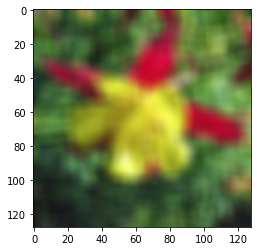

In [135]:
filterwarnings("ignore") 
tf_img = io.read_file(groups[5] [0])
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)

<dtype: 'uint8'>


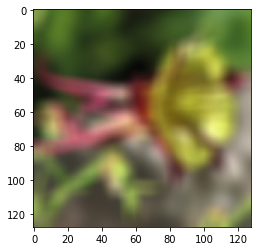

In [136]:
filterwarnings("ignore") 
tf_img = io.read_file(groups[5] [1])
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)

<dtype: 'uint8'>


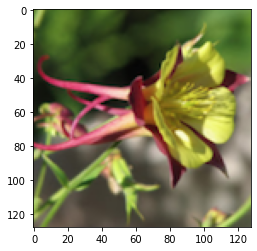

In [137]:
filterwarnings("ignore") 
tf_img = io.read_file(groups[1] [0])
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)

<dtype: 'uint8'>


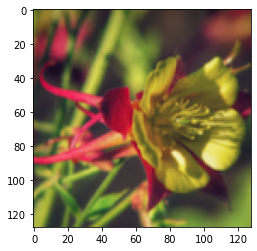

In [138]:
filterwarnings("ignore") 
tf_img = io.read_file(groups[1] [1])
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)

<dtype: 'uint8'>


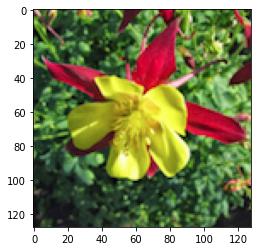

In [139]:
filterwarnings("ignore") 
tf_img = io.read_file(groups[1] [2])
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)